# All Mart - High Value Customer Identification

Identificação de clientes mais valiosos de uma empresa e projecção de um programa de fidelidade para os mesmos.

# Planejamento da Solução (IOT)

## Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
2. Conjunto de dados
     - Vendas de um e-commerce online, durante o período de um ano.

## Output - Saída

1. A indicação das pessoas que farão parte do programa de _insiders_
    - Lista: cliente_id | is_insider | 
    

2. Relatório com as respostas das perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa insiders?
    - Quantos clientes farõa parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível aos insiders?
    - Quais as condições para um apessoa ser removida dos insiders?
    - Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa insiders?
    - O que é ser elegível? O que são clientes ed maior "valor"?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV (LifeTime Value)
        - Baixa Recência
        - Alto "Basket Size" (cesta de compra)
        - Baixa probabilidade de Churn
        - Alta Previsão de LTV 
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução

    - Experiência de compra:
        - Alta média de avaliações
    
2. Quantos clientes farõa parte do grupo?
    - Número total de clientes
    - % do grupo _Insiders_
3. Quais as principais características desses clientes?
    - Idade
    - Localização
    
4. Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Faturamento total do ano
    - Faturamento do grupo _Insiders_
    
5. Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - LTV do grupo _Insiders_
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível aos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
    
7. Quais as condições para um apessoa ser removida dos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo

8. Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Teste de hipóteses
    - Teste A/B bayesiano
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import plotly.express as px

import re

from IPython.display import HTML
import matplotlib.font_manager



# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder


# Models
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans



# Visualização de clusters
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
import umap.umap_ as umap




import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    color_pal = sns.color_palette()
    plt.style.use('ggplot')
    sns.set()
jupyter_settings()

## 0.2 CFG

In [3]:
class CFG:
    FOLDS = 5
    seed = 1
    TARGET = ''
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 1.0 Data Reading

## 1.1 Data Loading

In [4]:
df1 = pd.read_csv('../data/01_raw/Ecommerce.csv', encoding='unicode_escape')
df1.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data Dimensions

In [5]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3 Data Dtypes

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4 Checking NA

In [7]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.0 Data Wrangling

In [8]:
df2 = df1.copy()

## 2.1 Rename Columns

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = cols_new

## 2.2 Replacing NAs

In [10]:
df2.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'Removed data: {1-(df2.shape[0]/df1.shape[0]):.2f}')

Removed data: 0.25


In [11]:
df2.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 2.3 Changing Dtypes

In [12]:
# Invoice Date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# Customer ID
df2['customer_id'] = df2['customer_id'].astype(int)

In [13]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 2.4 Drop Duplicates

In [14]:
# Create DataFrame Reference

df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 2.5 Descriptive Statistics

### 2.5.1. Numerical Features

In [15]:
num_cols = df2.select_dtypes(include=['number'])
cat_cols = df2.select_dtypes(exclude=['number', 'datetime64[ns]'])

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_cols.apply(np.mean)).T
ct2 = pd.DataFrame(num_cols.apply(np.median)).T


#  Dispersion - Desvio Padrão, minimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_cols.apply(np.std)).T
d2 = pd.DataFrame(num_cols.apply(np.min)).T
d3 = pd.DataFrame(num_cols.apply(np.max)).T
d4 = pd.DataFrame(num_cols.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_cols.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_cols.apply(lambda x: x.kurtosis())).T

# Concat
descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.69,0.18,94317.56
1,unit_price,0.00,38970.00,38970.00,3.46,1.95,69.32,452.22,246924.54
2,customer_id,12346.00,18287.00,5941.00,15287.69,15152.00,1713.60,0.03,-1.18


Investigar:
1. Quantidade negativa: pode significar "devolução"
2. Preço unitário igual a zero: pode ser promoção


### 2.5.1. Categorical Features

#### Invoice No

In [17]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

Problema: detectamos que Invoice_no apresenta letras além de números. Precisamos converter para inteiro.

In [18]:
df_invoices_cat = cat_cols.loc[cat_cols['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'invoice_no']

# o regex acima procura necessariamente por CARACTERES != de numeros (^) sendo 1 ou mais caracteres.

print(f'Número total de transações: {df_invoices_cat.shape[0]}')
print(f'Número total de quantidades negativas: {df2.loc[df2["quantity"] < 0].shape[0]}')

Número total de transações: 8905
Número total de quantidades negativas: 8905


Podemos assumir que quando há uma letra no "invoice_no" significa que esta transação foi retornada ou cancelada. A letra "C" provalmente é um indicativo de _charge back_ ("extorno", em inglês).

#### Stock Code

In [19]:
# Stock Code

cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()
# O regex acima procura por strings que DEVEM começar com uma letra(^), e DEVEM terminar ($) com uma letra OU MAIS (+)

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

Não sabemos o que significam essas siglas, por isso iremos removê-las nesse primeiro momento.

#### Description

In [20]:
df2['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

Iremos também deletar a variável description, por não apresentar informações relevantes neste primeiro momento.

#### Country

In [21]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

Uma das formas de avaliar uma região, é observar o quão representativo cada uma delas é em nosso dataset. Vamos observar a seguir:

In [22]:
df2['country'].value_counts(normalize=True).reset_index().head(10)

,index,country
0,United Kingdom,0.89
1,Germany,0.02
2,France,0.02
3,EIRE,0.02
4,Spain,0.01
5,Netherlands,0.01
6,Belgium,0.01
7,Switzerland,0.00
8,Portugal,0.00
9,Australia,0.00


Podemos visualizar também a quantidade de clientes únicos por país. Vamos visualizar os 10 países com mais clientes:

In [23]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


Os 10 países com menos clientes:

In [24]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).tail(10)

,country,customer_id
2,Bahrain,2
8,Czech Republic,1
21,Lithuania,1
20,Lebanon,1
27,RSA,1
28,Saudi Arabia,1
29,Singapore,1
16,Iceland,1
4,Brazil,1
11,European Community,1


# 3.0 Feature Filtering

Aqui tomaremos as ações decididas na seção anterior para selecionar da melhor forma as nossas features para análise.

In [25]:
df3 = df2.copy()

In [26]:
###### Numerical Cols ######

df3 = df3.loc[df3['unit_price'] > 0.04, :]


###### Categorical Cols ######

# Stock Code != [POST, D, M, DOT, CRUK]
df3 = df3.loc[~df3['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]


# Description
df3 = df3.drop(columns='description', axis=1)


# Map
df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]


# Quantity - negative numbers means product returns
df3_retornos = df3.loc[df3['quantity'] < 0, :]
df3_compras = df3.loc[df3['quantity'] > 0, :]


# 4.0 Feature Engineering

In [36]:
df4 = df3.copy()

In [37]:
# data referecen
df_ref = df4.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [38]:
# Gross Revenue (Faturamento = Quantidade * Preço)
df3_compras['gross_revenue'] = df3_compras['quantity'] * df3_compras['unit_price']

# Monetary
df_monetary = df3_compras[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')


# Recency: Dia da última compra
df_recency = df3_compras.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')

In [39]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = df3_compras[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.rename(columns={'gross_revenue':'monetary',
               'invoice_no':'frequency'},
             inplace=True)

In [40]:
# Avg Ticket - Ticket Médio
df_avg_ticket = df3_compras[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [42]:
df_ref.drop(columns='invoice_date', axis=1, inplace=True)
df_ref.head()

,customer_id,monetary,recency,frequency,avg_ticket
0,17850,5391.21,372.00,34.00,18.15
1,13047,3232.59,56.00,9.00,18.90
2,12583,6705.38,2.00,15.00,28.90
3,13748,948.25,95.00,5.00,33.87
4,15100,876.00,333.00,3.00,292.00


In [44]:
# # Gross Revenue (Faturamento = Quantidade * Preço)
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary: Faturamento
# df_monetary = df3.groupby('customer_id')['gross_revenue'].sum().reset_index()
# df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')

# # Recency: Dia da última compra
# df_recency = df3.groupby('customer_id')['invoice_date'].max().reset_index()
# df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')

# # Frequency - Contagem do número de compras feitas pelo cliente
# df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

# # Avg Ticket - Ticket Médio
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
# df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [43]:
# df_ref.drop('invoice_date', inplace=True, axis=1)
# df_ref.head()

# 5.0 EDA (Exploratory Data Analysis)

In [45]:
df5 = df_ref.dropna()
df5.isna().sum()

customer_id    0
monetary       0
recency        0
frequency      0
avg_ticket     0
dtype: int64

## 5.1. Univariate Analysis

# 6.0 Data Preparation & Feature Selection

In [46]:
df6 = df5.copy()

In [57]:
# Standard Scaler
ss = StandardScaler()

df6['monetary']   = ss.fit_transform(df6[['monetary']]  )
df6['recency']    = ss.fit_transform(df6[['recency']]   )
df6['frequency']  = ss.fit_transform(df6[['frequency']] )
df6['avg_ticket'] = ss.fit_transform(df6[['avg_ticket']])

In [58]:
df6.head()

,customer_id,monetary,recency,frequency,avg_ticket
0,17850,0.38,2.79,3.89,-0.03
1,13047,0.14,-0.36,0.62,-0.03
2,12583,0.53,-0.90,1.41,-0.03
3,13748,-0.12,0.03,0.10,-0.02
4,15100,-0.13,2.40,-0.16,0.15


# 7.0 Hyperparameter Fine-tuning

In [59]:
X = df6.drop(columns=['customer_id'])

In [60]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

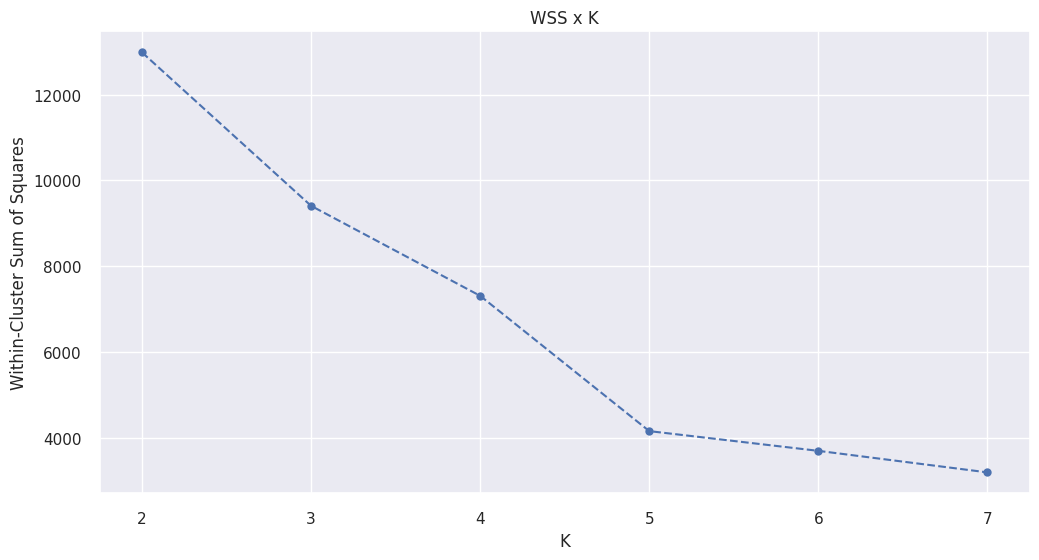

In [61]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=CFG.seed)
    
    # model training
    kmeans.fit(X)
    
    # validation    
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method - Método Cotovelo
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('WSS x K');

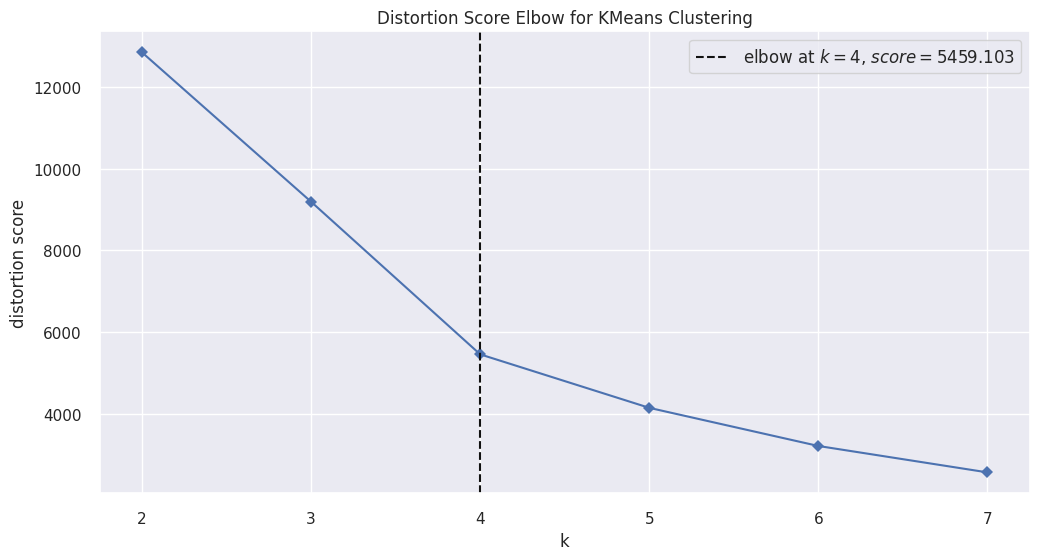

In [62]:
kmeans = KElbowVisualizer(KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score

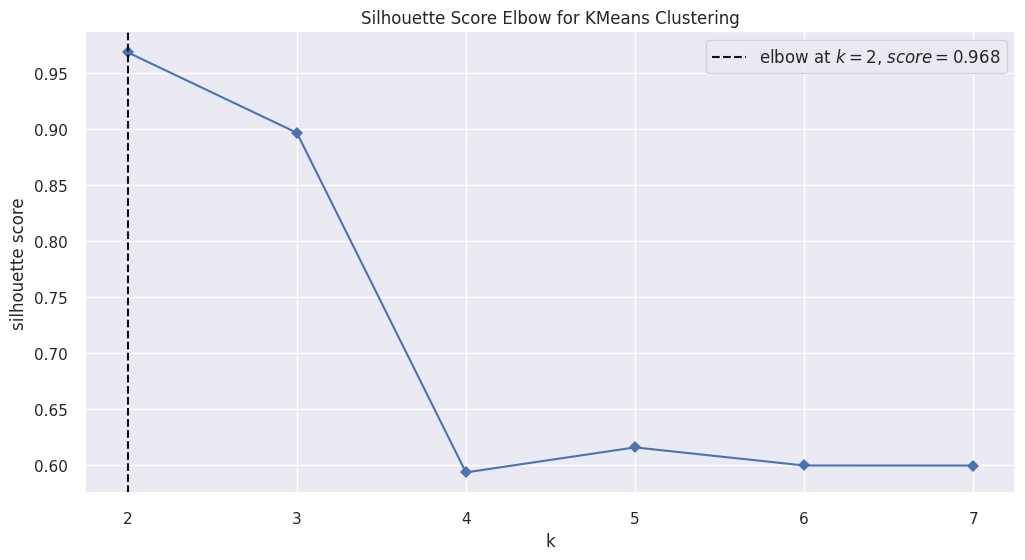

In [63]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

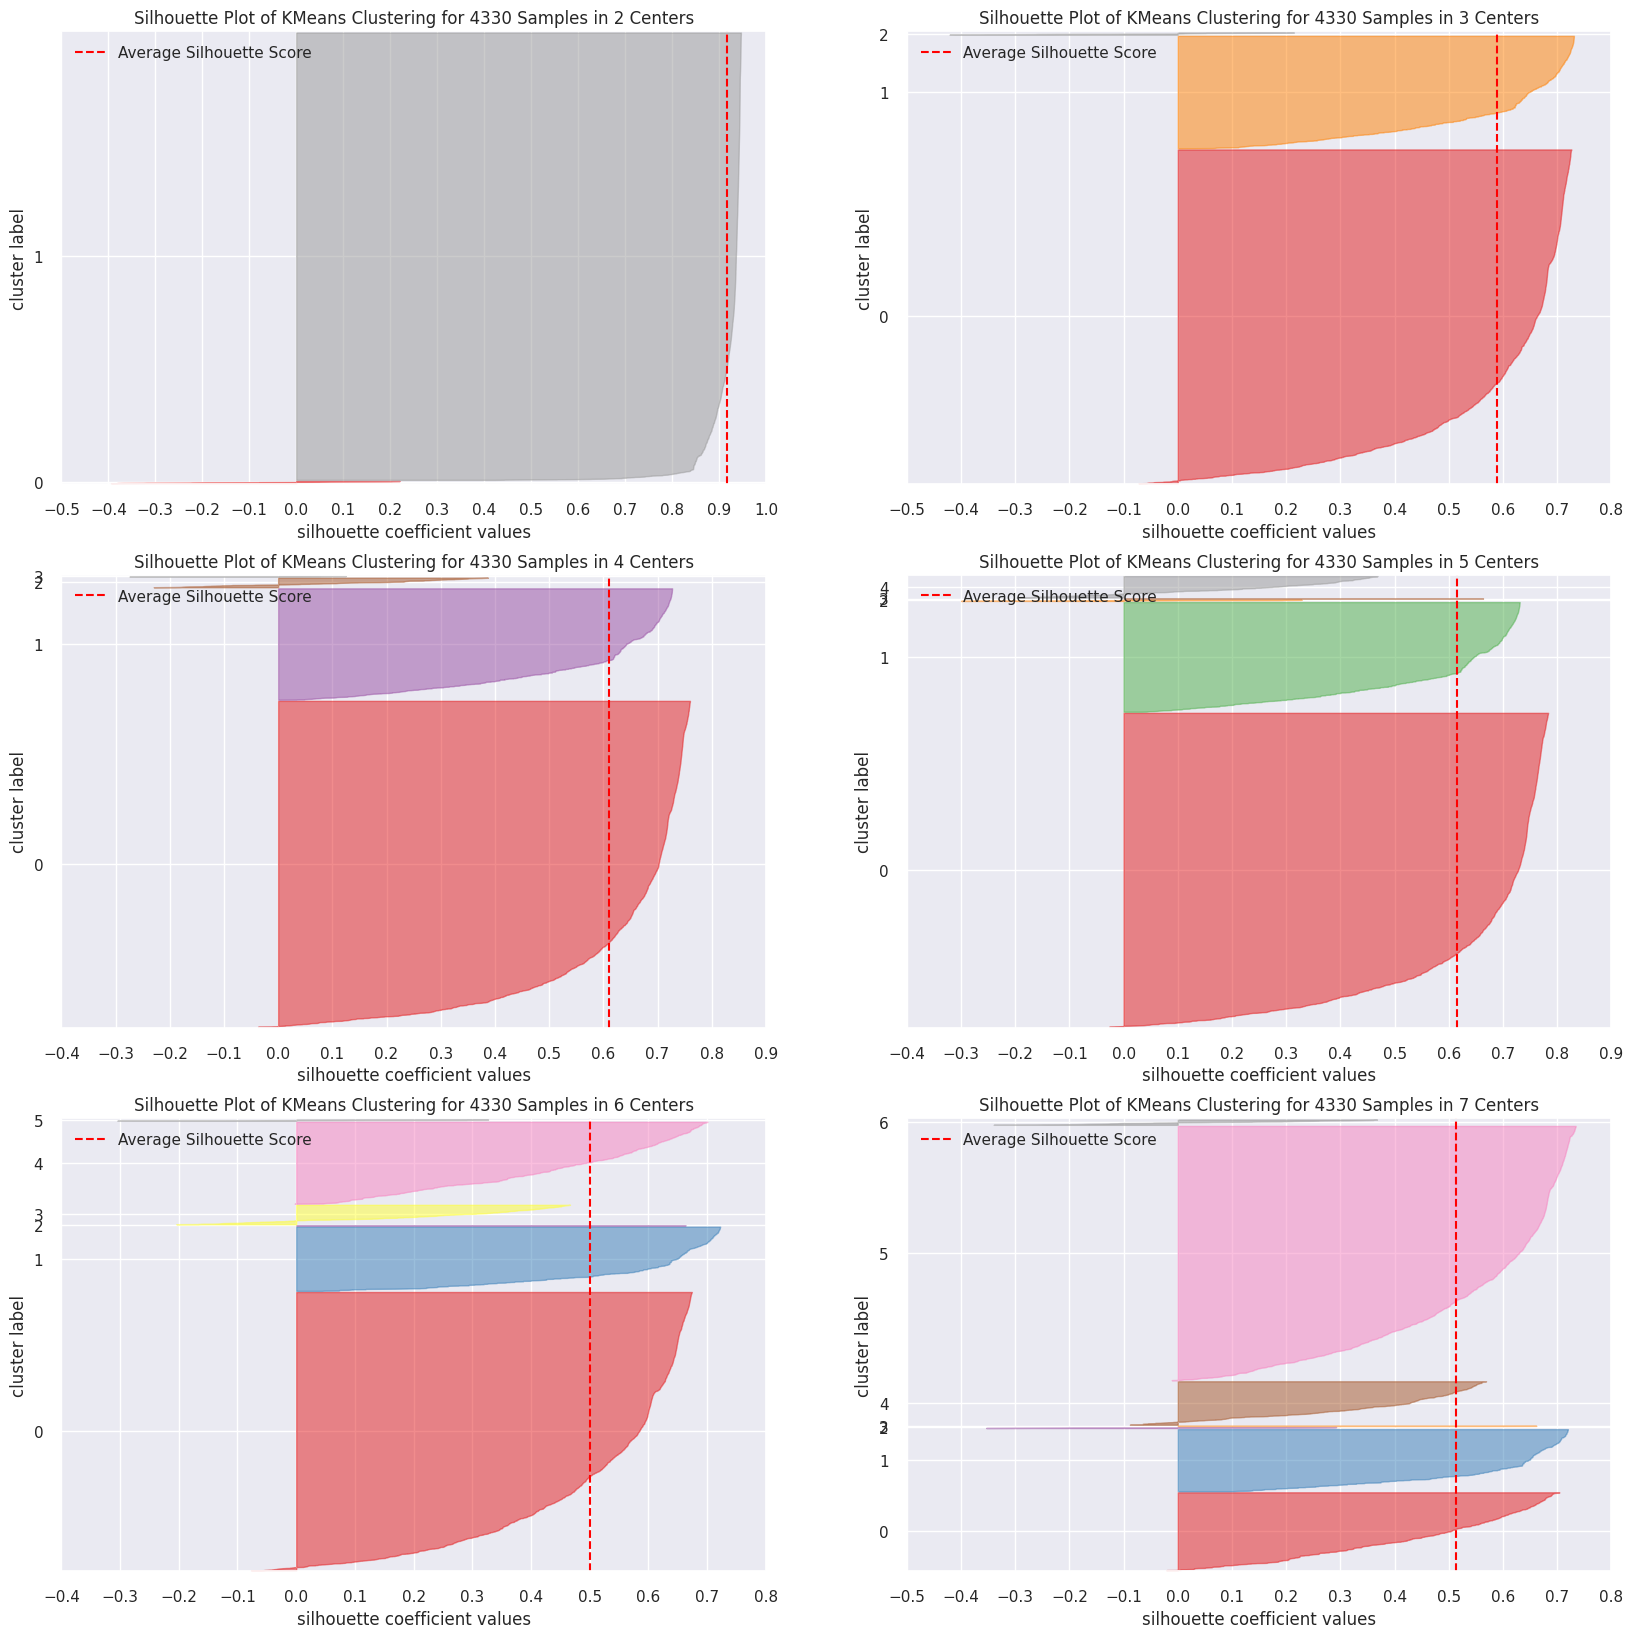

In [64]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=CFG.seed)
    q, mod = divmod(k, 2)
    viz = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    viz.fit(X)
    viz.finalize()

# 8.0 Model Training

## 8.1. K-Means

In [65]:
# model definition
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.predict(X) # ou kmeans.labels_

## 8.2. Cluster Validation

In [66]:
## WSS 
print(f'WSS value:{kmeans.inertia_}')

## SS
print(f'SS value: {silhouette_score(X, labels, metric="euclidean")}')

WSS value:9408.255050647302
SS value: 0.5893633811956627


# 9.0 Cluster Analysis

In [71]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,monetary,recency,frequency,avg_ticket,cluster
0,17850,0.38,2.79,3.89,-0.03,1
1,13047,0.14,-0.36,0.62,-0.03,2
2,12583,0.53,-0.90,1.41,-0.03,2
3,13748,-0.12,0.03,0.10,-0.02,2
4,15100,-0.13,2.40,-0.16,0.15,1


## 9.1. Visualization Inspection

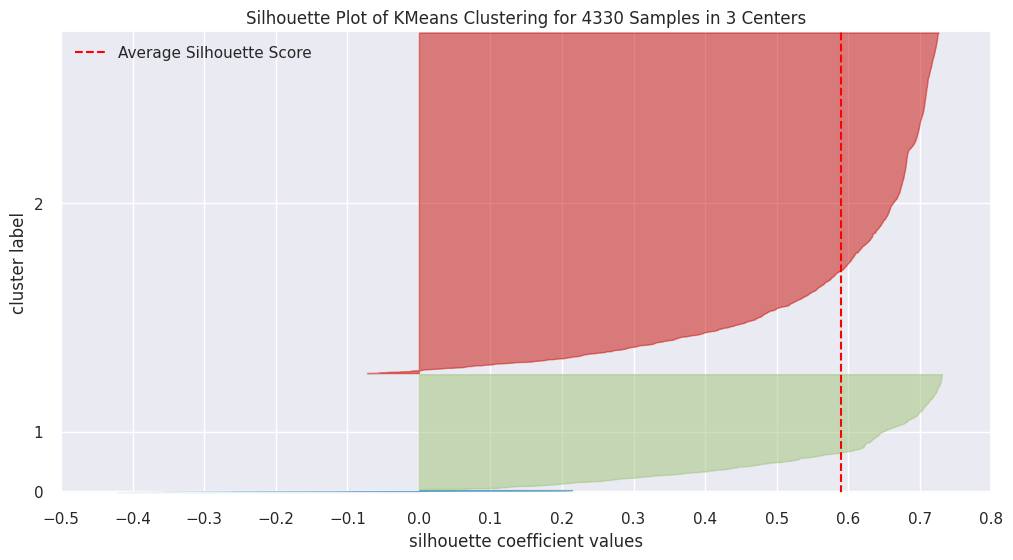

In [67]:
viz = SilhouetteVisualizer(kmeans, colors='yellowbrick')
viz.fit(X)
viz.finalize()

## 9.2. Two-Dimensional Plot

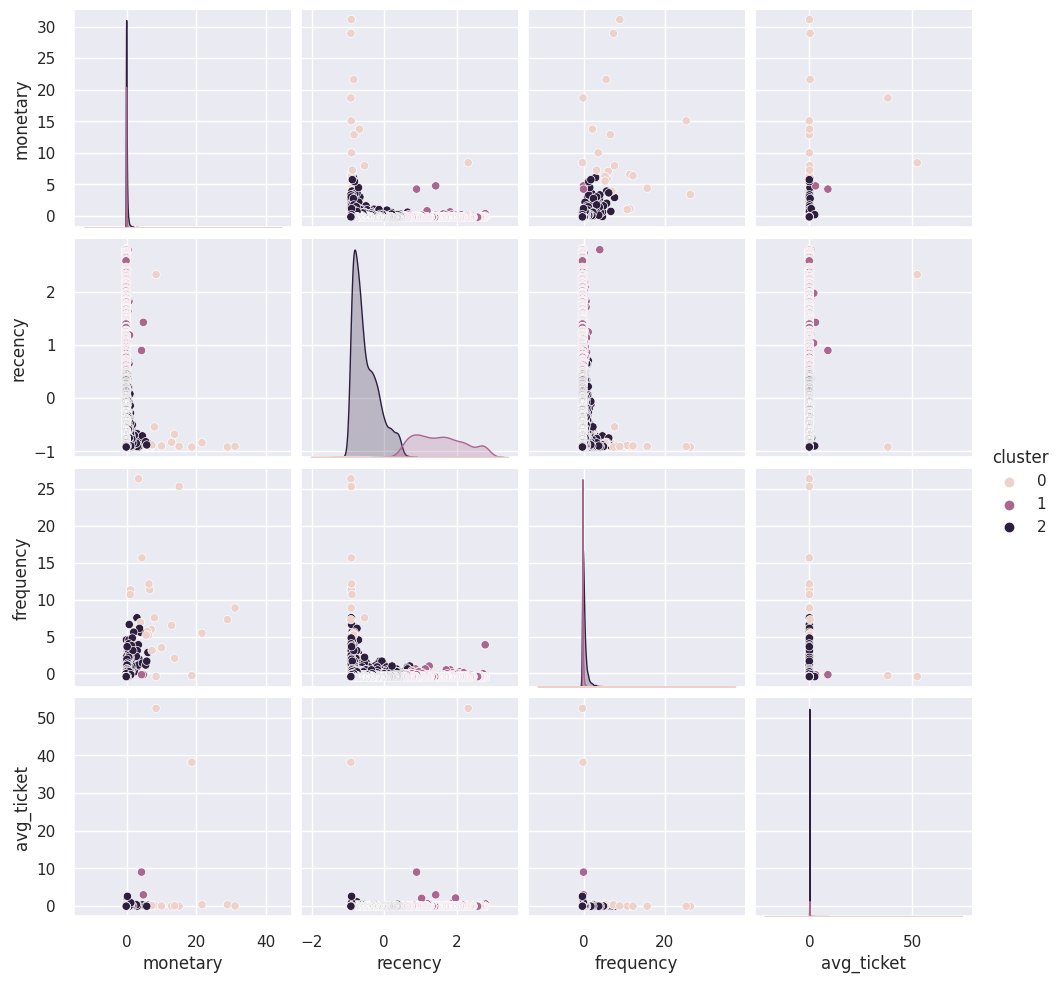

In [72]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3. UMAP

In [68]:
X.head()

,monetary,recency,frequency,avg_ticket
0,0.38,2.79,3.89,-0.03
1,0.14,-0.36,0.62,-0.03
2,0.53,-0.90,1.41,-0.03
3,-0.12,0.03,0.10,-0.02
4,-0.13,2.40,-0.16,0.15


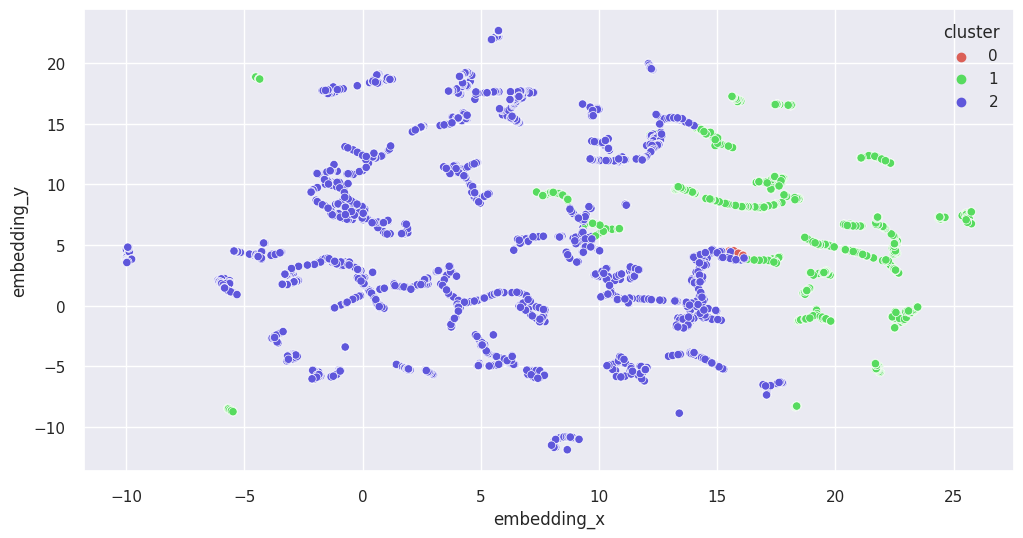

In [75]:
reducer = umap.UMAP(n_neighbors=5, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=df_viz['cluster'].nunique()),
               data=df_viz);

In [76]:
## fig = px.scatter_3d(df9, x='recency', y='frequency', z='monetary', color='cluster')
# fig.show()

## 9.4. Cluster Profile

In [77]:
df9.head()

,customer_id,monetary,recency,frequency,avg_ticket,cluster
0,17850,0.38,2.79,3.89,-0.03,1
1,13047,0.14,-0.36,0.62,-0.03,2
2,12583,0.53,-0.90,1.41,-0.03,2
3,13748,-0.12,0.03,0.10,-0.02,2
4,15100,-0.13,2.40,-0.16,0.15,1


In [78]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg Monetary
df_avg_monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, on='cluster')

# Avg recency days
df_avg_recency = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster')

# Avg frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster')

df_cluster

,cluster,customer_id,perc_customer,monetary,recency,frequency,avg_ticket
0,0,22,0.51,10.33,-0.72,8.44,4.19
1,1,1086,25.08,-0.16,1.54,-0.35,-0.01
2,2,3222,74.41,-0.02,-0.51,0.06,-0.03


**Exemplo de leitura da tabela:**

- No cluster 1: composto por 6 pessoas, que gastaram 182.000 dólares em média, com uma recência média super baixa, pois compram a cada 7 dias (compram toda semana), comprando em média 90 produtos.

### Cluster 01:  (Premium - Candidato à Insider)
    - Número de customers: 6 (0,14% dos clientes)
    - Recência média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: U$ 182.182,00 
    
### Cluster 02: (VIPs)
    - Número de customers: 31 (0,71% dos clientes)
    - Recência média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: U$ 40.543,52 
    
### Cluster 03: (Ocasionais)
    - Número de customers: 4.335 (99% dos clientes)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: U$ 1.372,57 


# 10.0 Deployment

# 11.0 SandBox

## 11.1. Original Dataset

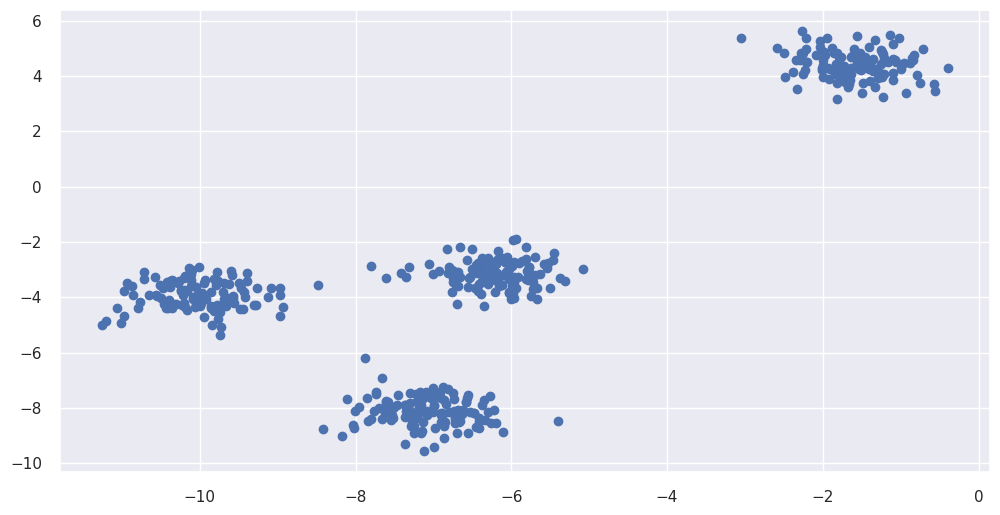

In [49]:
from sklearn.datasets import make_blobs #cria pontos no espaço

X, y = make_blobs(n_samples=500, n_features=2, 
                  centers=4,
                  cluster_std=0.5,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=CFG.seed)
# plot dataset
plt.scatter(X[:, 0], X[:, 1])

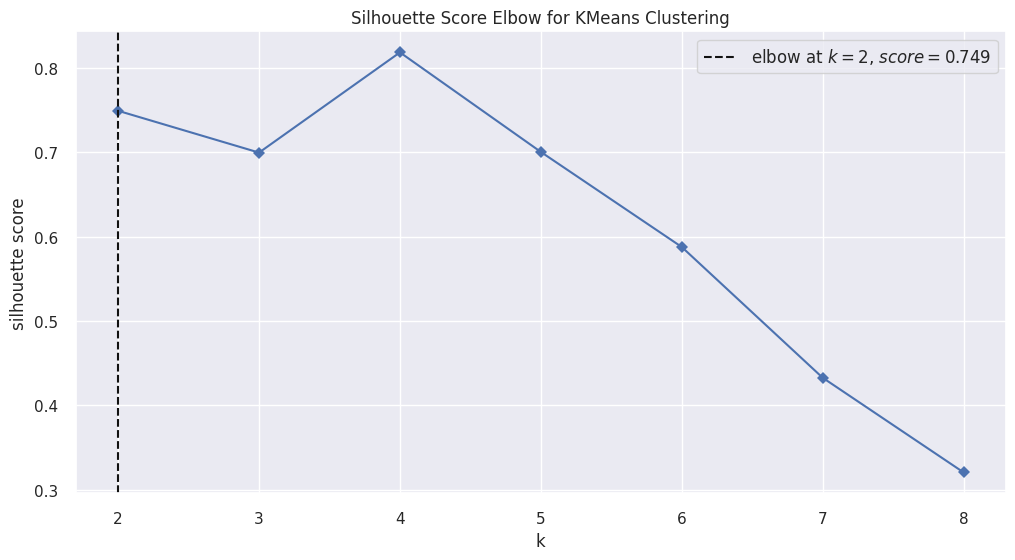

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [50]:
# modeling
clusters = list(range(2, 9))
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## 11.2. Silhouette Analysis

IndexError: index 2 is out of bounds for axis 0 with size 2

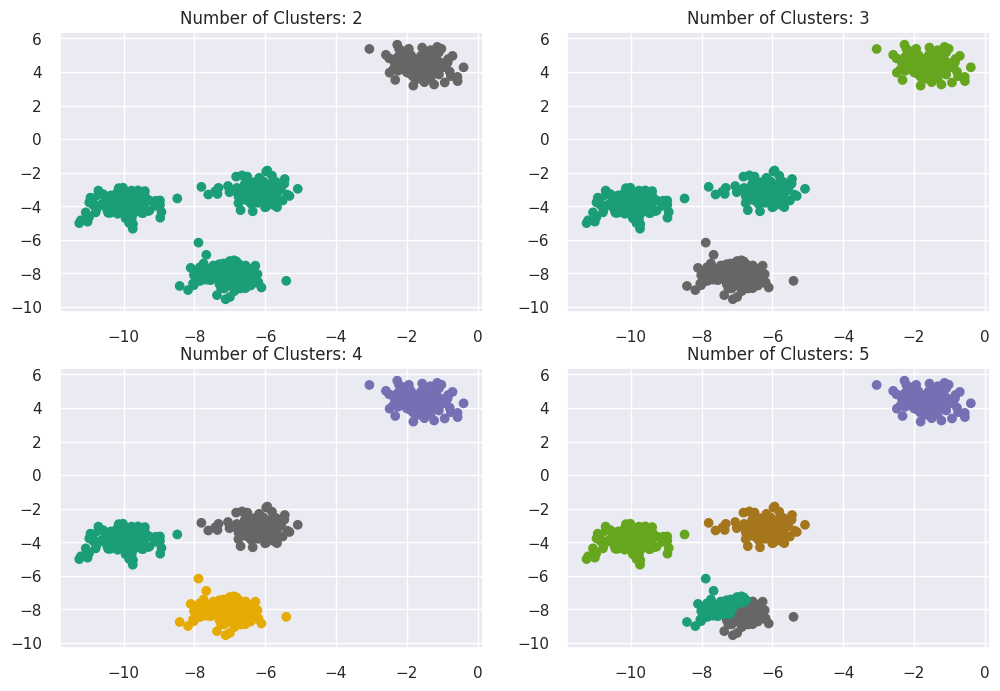

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    kmeans.fit(X)
    
    q, mod = divmod(i, 2)
    ax[q-1, mod].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=plt.cm.Dark2)
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(i))
plt.show()

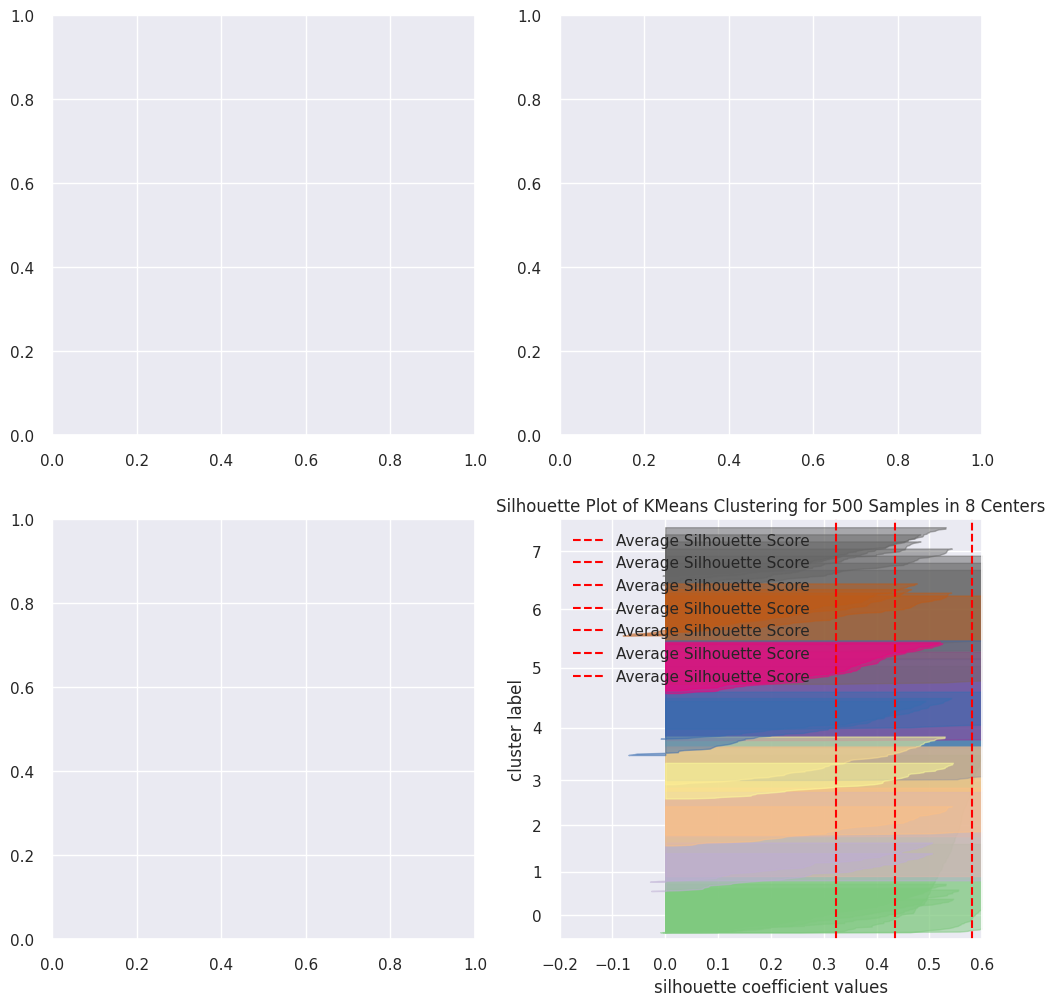

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(kmeans, colors='Accent')
    visualizer.fit(X)
    visualizer.finalize()